In [26]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, classification_report

In [2]:
# loading the preprocessed dataset
file_path = "../data/preprocessed_breast_cancer_data.csv"  # Update path if necessary
data = pd.read_csv(file_path)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   patient_id                      2509 non-null   object 
 1   age_at_diagnosis                2509 non-null   float64
 2   type_of_breast_surgery          2509 non-null   object 
 3   cancer_type                     2509 non-null   object 
 4   cancer_type_detailed            2509 non-null   object 
 5   cellularity                     2509 non-null   object 
 6   chemotherapy                    2509 non-null   int64  
 7   pam50_+_claudin-low_subtype     2509 non-null   object 
 8   cohort                          2509 non-null   float64
 9   er_status_measured_by_ihc       2509 non-null   object 
 10  er_status                       2509 non-null   int64  
 11  neoplasm_histologic_grade       2509 non-null   float64
 12  her2_status_measured_by_snp6    25

In [4]:
# select relevant features
features = ["age_at_diagnosis", "tumor_size", "tumor_stage", "chemotherapy", "hormone_therapy",
           "her2_status", "pr_status", "er_status", "mutation_count", "nottingham_prognostic_index"]

# target varaible
target = "overall_survival_status"

In [5]:
data_ml = data[features + [target]].copy() 

In [6]:
# dropping the target columns from the training data
X = data_ml.drop(columns=[target])

# define y
y = data_ml[target]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

In [8]:
# scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
# Logistic Regression Model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_logreg = log_reg.predict(X_test_scaled)
y_pred_logreg_prob = log_reg.predict_proba(X_test_scaled)[:, 1]
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_logreg))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.57      0.28      0.38       167
           1       0.71      0.89      0.79       335

    accuracy                           0.69       502
   macro avg       0.64      0.59      0.58       502
weighted avg       0.66      0.69      0.65       502



**Observations**
- Performs poorly for Class 0 (Alive) (F1-score=0.38)
- Strong recall for Class 1 (Deceased) (89%), meaning it correctly identifies high-risk patients well.
- Overall accuracy is 69%, but performance is imbalanced.

In [22]:
# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_rf_prob = rf_model.predict_proba(X_test_scaled)[:, 1]
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))

Random Forest Results:
              precision    recall  f1-score   support

           0       0.55      0.49      0.52       167
           1       0.76      0.80      0.78       335

    accuracy                           0.70       502
   macro avg       0.65      0.65      0.65       502
weighted avg       0.69      0.70      0.69       502



**Observations**
- Performs better on Class 0 (F1-score = 0.52, up from 0.38).
- Overall accuracy improved slightly to 70%.
- A more balanced classification compared to Logistic Regression.

In [23]:
# Optimized XGBoost Model
xgb_model = XGBClassifier(n_estimators=50, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_xgb_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]
print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Results:
              precision    recall  f1-score   support

           0       0.55      0.56      0.55       167
           1       0.78      0.77      0.78       335

    accuracy                           0.70       502
   macro avg       0.66      0.67      0.66       502
weighted avg       0.70      0.70      0.70       502



**Observations**
- Best balance between Class 0 and Class 1.
- Slightly lower recall for Class 1, but higher precision than other models.
- Best F1-score for Class 0 (0.55), meaning it handles both classes more evenly.
- Best macro-average F1-score (0.66), meaning the overall model is performing better across both classes.

In [24]:
# Compute ROC curve and AUC for each model
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_logreg_prob)
roc_auc_log = auc(fpr_log, tpr_log)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_prob)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb_prob)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

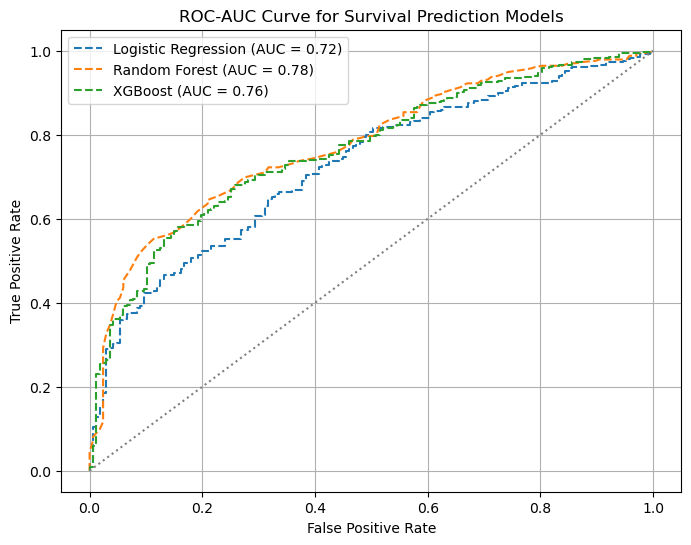

In [25]:
# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_log:.2f})', linestyle='--')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})', linestyle='--')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})', linestyle='--')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], color='gray', linestyle='dotted')

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Survival Prediction Models")
plt.legend()
plt.grid()

# Show plot
plt.show()

**Observations**
1. **AUC Scores**:
    - **Logistic Regression: 0.72** (performs the worst)
    - **Random Forest: 0.78** (best performance)
    - **XGBoost: 0.76** (slightly worse than Random Forest)

2. **Model Comparison**:
    - **Random Forest** has the **best AUC**, meaning it's better at distinguishing between survivors and non-survivors.
    - **XGBoost performs slightly similar to Random Forest** but is slightly worse.
    - **Logistic Regression is the weakest model** in this comparison.

### Performing Feature Importance

To understand which factors most influence the survival prediction

1. **For Random Forest & XGBoost**:
    - Extract feature importances from the models.

2. **For Logistic Regression**:
    - Use the model's **coefficients** to interpret how each feature impacts survival.

In [27]:
# extract feature importance from Random Forest and XGBoost
feature_names = X.columns

# Random Forest feature importance
rf_importance = rf_model.feature_importances_

# XGBoost Feature Importance
xgb_importance = xgb_model.feature_importances_

# Logistic Regression Coefficients
log_reg_coefficients = np.abs(log_reg.coef_)[0]  # considering absolute values

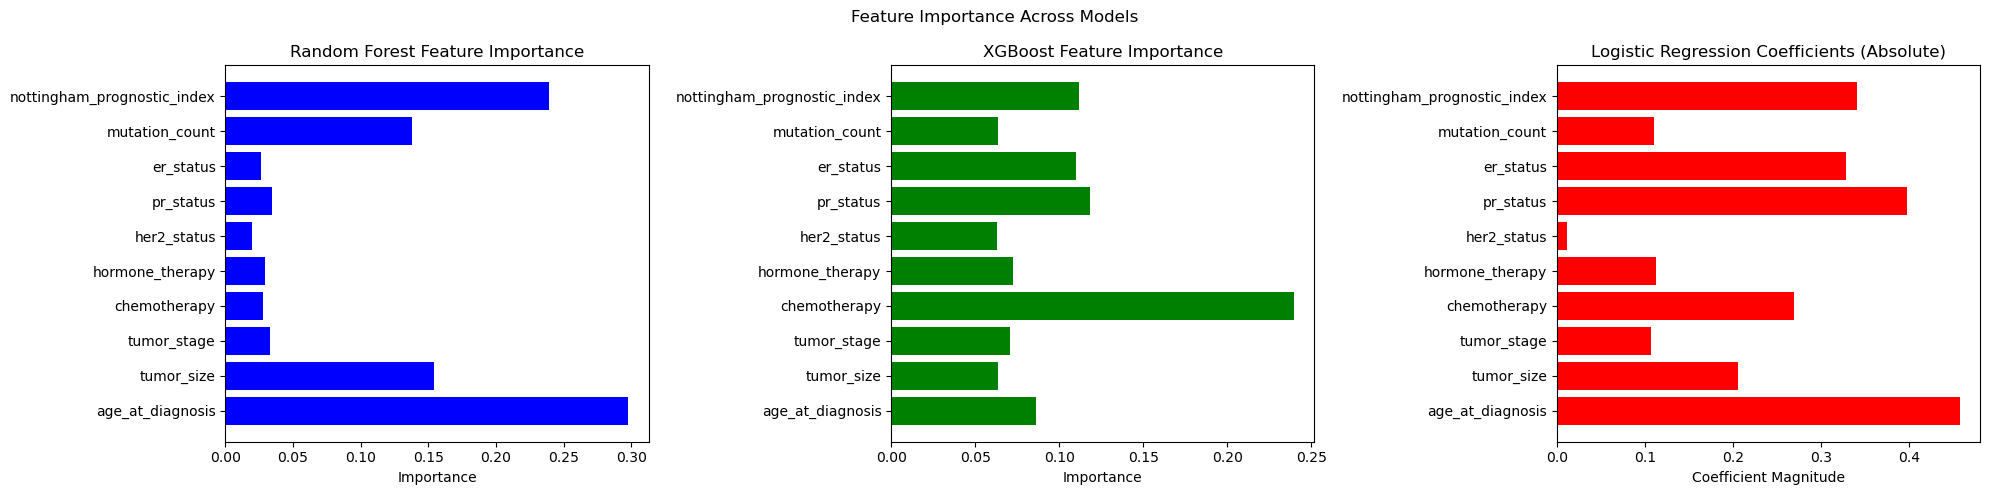

In [30]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle("Feature Importance Across Models")

# Plot Random Forest Feature Importance
axes[0].barh(feature_names, rf_importance, color="blue")
axes[0].set_title("Random Forest Feature Importance")
axes[0].set_xlabel("Importance")

# Plot XGBoost Feature Importance
axes[1].barh(feature_names, xgb_importance, color="green")
axes[1].set_title("XGBoost Feature Importance")
axes[1].set_xlabel("Importance")

# Plot Logistic Regression Coefficients
axes[2].barh(feature_names, log_reg_coefficients, color="red")
axes[2].set_title("Logistic Regression Coefficients (Absolute)")
axes[2].set_xlabel("Coefficient Magnitude")

# Adjust layout and show plot
plt.tight_layout()
plt.show()